In [1]:
!pip install opendatasets --upgrade --quiet
%config Completer.use_jedi = False
%matplotlib inline

In [2]:
import torch
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
import sklearn
import time
import copy
import glob
import random
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,  DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34


In [3]:
# get the data from
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadikhalas
Your Kaggle Key: ··········


100%|██████████| 107M/107M [00:00<00:00, 126MB/s] 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [5]:
ROOT_DIR = "/content/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))



In [6]:
number_of_images.items()

dict_items([('Brain Tumor', 2513), ('Healthy', 2087)])

In [7]:
def dataFolder(p, split):
  # we will create a train folder

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
     os.makedirs("./"+p+"/"+dir)

     for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                size = (math.floor(split*number_of_images[dir])-10),
                                replace=False):
       O = os.path.join(ROOT_DIR, dir, img) #path
       D = os.path.join("./"+p,dir)
       shutil.copy(O,D)
       os.remove(O)

  else:
    print(f"{p} Folder exsist")


In [8]:
dataFolder("train", 0.8)

In [9]:
dataFolder("test", 0.20)

In [10]:
train_healthy = glob.glob("/content/brain_tumor/train/Healthy/*")
train_brainTumor = glob.glob("/content/brain_tumor/train/Brain Tumor/*")


test_healthy = glob.glob("/content/brain_tumor/test/Healthy/*")
test_brainTumor = glob.glob("/content/brain_tumor/test/Brain Tumor/*")


In [ ]:
train_healthy

In [13]:
train_paths = train_healthy + train_brainTumor
test_paths = test_healthy + test_brainTumor

In [14]:
train_labels = [0] * len(train_healthy) + [1] * len(train_brainTumor)
test_labels = [0] * len(test_healthy) + [1] * len(test_brainTumor)

In [15]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))

3659 3659
899 899


In [16]:
train_paths, valid_paths, train_labels, valid_lables = train_test_split(train_paths,train_labels,stratify = train_labels)



In [17]:
def show_random_images():
  path_random_normal = random.choice(train_healthy)
  path_random_abnormal = random.choice(train_brainTumor)

  flg = plt.figure(figsize=(10, 10))

  ax1 = plt.subplot(1, 2, 1)
  ax1.imshow(Image.open(path_random_normal).convert("LA"))
  ax1.set_title("Healthy X-ray")


  ax2 = plt.subplot(1, 2, 2)
  ax2.imshow(Image.open(path_random_abnormal).convert("LA"))
  ax2.set_title("Brain Tumor X-ray")

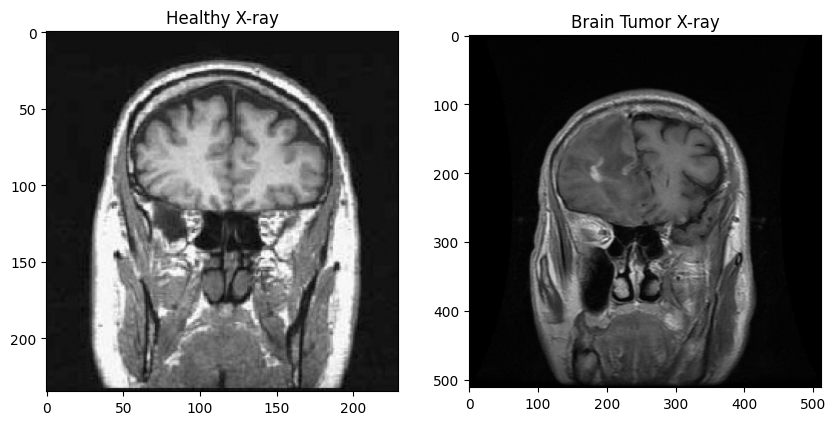

In [18]:
show_random_images()

In [19]:
class XrayDataset(Dataset):
  def __init__(self, paths, labels, transform=None):
    self.paths = paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    path = self.paths[index]
    image = Image.open(path).convert("RGB")

    if self.transform:
      image = self.transform(image)

    label = self.labels[index]
    label = torch.tensor([label])

    return image, label


In [20]:
train_dataset = XrayDataset(train_paths, train_labels)

In [21]:
len(train_dataset)

2744

In [22]:
next(iter(train_dataset))

(<PIL.Image.Image image mode=RGB size=287x348>, tensor([1]))

In [23]:
resnet = resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
class BraintumorNet(nn.Module):
  def __init__(self, pretrained=True):
    super(BraintumorNet, self).__init__()
    self.backbone = resnet18(pretrained = pretrained)
    self.fc = nn.Linear(in_features=512, out_features=1)

  def forward(self, x):
    x = self.backbone.conv1(x)
    x = self.backbone.bn1(x)
    x = self.backbone.relu(x)
    x = self.backbone.maxpool(x)

    x = self.backbone.layer1(x)
    x = self.backbone.layer2(x)
    x = self.backbone.layer3(x)
    x = self.backbone.layer4(x)

    x = self.backbone.avgpool(x)

    x = x.view(x.size(0), 512)
    x = self.fc(x)

    return x



In [25]:

image_size = (500, 500)

train_transform = transforms.Compose([
  transforms.ToTensor(), transforms.RandomRotation (degrees=15),
  transforms.Resize(size=image_size),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform= transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize(size = image_size),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.2251])])

train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_lables, test_transform)

In [26]:
pretrained = True

model = BraintumorNet(pretrained=pretrained)
num_epochs = 5
lr = 3e-3
train_batch_size=16
valid_batch_size=16
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val": valid_dataloader
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"])//10
}

data_sizes = {
    "train": len(train_dataset),
    "val": len(valid_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": valid_batch_size
}


criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current 

In [27]:
def get_default_device():
  """ Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [28]:

device = get_default_device()
device

device(type='cuda')

In [29]:
model = model.to(device)
model

BraintumorNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [30]:
! nvidia-smi

Sun Sep 10 11:13:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |    663MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
def train_model(model, criterion, optimizer, num_epochs, device="cuda"):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0

  for epoch in tqdm(range(num_epochs), leave=False):
    for phase in ["train", "val"]:
      if phase == "train":
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for i , (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                       leave=False,
                                       total=len(dataloaders[phase])):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
              outputs = model(inputs)

              preds = outputs.sigmoid()>0.5
              loss = criterion(outputs, labels.float())

              if phase == "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i % logging_steps[phase] == 0 and i > 0:
              avg_loss = running_loss / ((i+1) * batch_sizes[phase])
              avg_acc = running_corrects / ((i+1) * batch_sizes[phase])

              print(f"[{phase}]: {epoch+1} / {num_epochs} | loss : {avg_loss} | acc : {avg_acc}")

      epoch_loss = running_loss / data_sizes[phase]
      epoch_acc = running_corrects.double() / data_sizes[phase]

      print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

      if phase == "val" and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f"Training took {time_elapsed} seconds")

  model.load_state_dict(best_model_wts)

  return model

# Now you can call train_model with your defined variables
model = train_model(model, criterion, optimizer, num_epochs)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[train]: 1 / 5 | loss : 0.8914527826839023 | acc : 0.5173611044883728
[train]: 1 / 5 | loss : 0.7877574103219168 | acc : 0.5660714507102966
[train]: 1 / 5 | loss : 0.7619939801784662 | acc : 0.572115421295166
[train]: 1 / 5 | loss : 0.7345718007156814 | acc : 0.5851449370384216
[train]: 1 / 5 | loss : 0.7145040672878886 | acc : 0.5908430218696594
[train]: 1 / 5 | loss : 0.6972846151555626 | acc : 0.6080096960067749
[train]: 1 / 5 | loss : 0.6878472012778123 | acc : 0.6109375357627869
[train]: 1 / 5 | loss : 0.6829502971938056 | acc : 0.6108576655387878
[train]: 1 / 5 | loss : 0.6763259166633928 | acc : 0.6132305264472961
[train]: 1 / 5 | loss : 0.669923802565413 | acc : 0.6184210777282715
train Loss: 0.6706 Acc: 0.6173


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/58 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[val]: 1 / 5 | loss : 1.283453146616618 | acc : 0.5104166865348816
[val]: 1 / 5 | loss : 1.2425564960999922 | acc : 0.5284091234207153
[val]: 1 / 5 | loss : 1.202662829309702 | acc : 0.54296875
[val]: 1 / 5 | loss : 1.1632855108806066 | acc : 0.5595238208770752
[val]: 1 / 5 | loss : 1.157990574836731 | acc : 0.5625
[val]: 1 / 5 | loss : 1.1658315620114725 | acc : 0.5584677457809448
[val]: 1 / 5 | loss : 1.1630938351154327 | acc : 0.5607638955116272
[val]: 1 / 5 | loss : 1.1540859268932808 | acc : 0.5609756112098694
[val]: 1 / 5 | loss : 1.1649417980857517 | acc : 0.5557065606117249
[val]: 1 / 5 | loss : 1.1642516395624947 | acc : 0.5539215803146362
[val]: 1 / 5 | loss : 1.1750409656337328 | acc : 0.5491071939468384
val Loss: 1.1829 Acc: 0.5454



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/172 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[train]: 2 / 5 | loss : 0.6119696531030867 | acc : 0.6770833134651184
[train]: 2 / 5 | loss : 0.6372142195701599 | acc : 0.6482142806053162
[train]: 2 / 5 | loss : 0.6368123992131307 | acc : 0.634615421295166
[train]: 2 / 5 | loss : 0.6256798618081687 | acc : 0.64402174949646
[train]: 2 / 5 | loss : 0.6151557232058326 | acc : 0.6649709343910217
[train]: 2 / 5 | loss : 0.611610476831788 | acc : 0.666262149810791
[train]: 2 / 5 | loss : 0.5991552732884884 | acc : 0.6796875596046448
[train]: 2 / 5 | loss : 0.5922012709788163 | acc : 0.6847627758979797
[train]: 2 / 5 | loss : 0.5864731495256548 | acc : 0.6903409361839294
[train]: 2 / 5 | loss : 0.5844983387063121 | acc : 0.6929824352264404
train Loss: 0.5842 Acc: 0.6931


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/58 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[val]: 2 / 5 | loss : 1.2855614920457203 | acc : 0.75
[val]: 2 / 5 | loss : 2.053077291358601 | acc : 0.6875
[val]: 2 / 5 | loss : 2.058083152398467 | acc : 0.69921875
[val]: 2 / 5 | loss : 1.8703845469724565 | acc : 0.6964285969734192
[val]: 2 / 5 | loss : 1.8477260665251658 | acc : 0.6899038553237915
[val]: 2 / 5 | loss : 1.860079033720878 | acc : 0.6915322542190552
[val]: 2 / 5 | loss : 1.706191274854872 | acc : 0.6961805820465088
[val]: 2 / 5 | loss : 1.5675388051242363 | acc : 0.707317054271698
[val]: 2 / 5 | loss : 1.8455722694811614 | acc : 0.698369562625885
[val]: 2 / 5 | loss : 1.960467717226814 | acc : 0.7022058963775635
[val]: 2 / 5 | loss : 2.0825164445808957 | acc : 0.7020089626312256
val Loss: 2.0484 Acc: 0.7049



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/172 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[train]: 3 / 5 | loss : 0.5388478686412176 | acc : 0.7638888955116272
[train]: 3 / 5 | loss : 0.5338686968599047 | acc : 0.7464285492897034
[train]: 3 / 5 | loss : 0.522099929360243 | acc : 0.7632212042808533
[train]: 3 / 5 | loss : 0.49995282681091974 | acc : 0.7744565606117249
[train]: 3 / 5 | loss : 0.499851034650969 | acc : 0.7732558250427246
[train]: 3 / 5 | loss : 0.5076884394421161 | acc : 0.7718446850776672
[train]: 3 / 5 | loss : 0.5188060600310564 | acc : 0.7625000476837158
[train]: 3 / 5 | loss : 0.5109678966938144 | acc : 0.7632299065589905
[train]: 3 / 5 | loss : 0.5201915431912844 | acc : 0.756899356842041
[train]: 3 / 5 | loss : 0.5312493202107692 | acc : 0.7489035129547119
train Loss: 0.5312 Acc: 0.7485


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/58 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[val]: 3 / 5 | loss : 1.0836536486943562 | acc : 0.5104166865348816
[val]: 3 / 5 | loss : 1.09561410817233 | acc : 0.5
[val]: 3 / 5 | loss : 1.1206896528601646 | acc : 0.48828125
[val]: 3 / 5 | loss : 1.1145410679635548 | acc : 0.4821428656578064
[val]: 3 / 5 | loss : 1.0983400367773497 | acc : 0.48557692766189575
[val]: 3 / 5 | loss : 1.1028522079990757 | acc : 0.4818548262119293
[val]: 3 / 5 | loss : 1.0982647091150284 | acc : 0.4809027910232544
[val]: 3 / 5 | loss : 1.0977810708487905 | acc : 0.4862804710865021
[val]: 3 / 5 | loss : 1.0797287977260093 | acc : 0.49184784293174744
[val]: 3 / 5 | loss : 1.0733238446946238 | acc : 0.4950980544090271
[val]: 3 / 5 | loss : 1.0650967668209756 | acc : 0.4977678656578064
val Loss: 1.0628 Acc: 0.5005



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/172 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[train]: 4 / 5 | loss : 0.49338708486821914 | acc : 0.7361111044883728
[train]: 4 / 5 | loss : 0.4505794712475368 | acc : 0.7946428656578064
[train]: 4 / 5 | loss : 0.4710391332896856 | acc : 0.7848557829856873
[train]: 4 / 5 | loss : 0.46612561202567554 | acc : 0.7862318754196167
[train]: 4 / 5 | loss : 0.44544558019139047 | acc : 0.7986918687820435
[train]: 4 / 5 | loss : 0.4553627389148601 | acc : 0.7949029207229614
[train]: 4 / 5 | loss : 0.4539752451082071 | acc : 0.7973958849906921
[train]: 4 / 5 | loss : 0.4512185916630891 | acc : 0.7997262477874756
[train]: 4 / 5 | loss : 0.44718542743425865 | acc : 0.8031655550003052
[train]: 4 / 5 | loss : 0.4415857784929331 | acc : 0.807748556137085
train Loss: 0.4409 Acc: 0.8083


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/58 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[val]: 4 / 5 | loss : 2.014857272307078 | acc : 0.5416666865348816
[val]: 4 / 5 | loss : 2.127490910616788 | acc : 0.5227273106575012
[val]: 4 / 5 | loss : 2.1721062064170837 | acc : 0.5078125
[val]: 4 / 5 | loss : 2.131424131847563 | acc : 0.5029761791229248
[val]: 4 / 5 | loss : 2.092432288023142 | acc : 0.509615421295166
[val]: 4 / 5 | loss : 2.062263930997541 | acc : 0.5080645084381104
[val]: 4 / 5 | loss : 2.02484721938769 | acc : 0.5121527910232544
[val]: 4 / 5 | loss : 1.9997614389512597 | acc : 0.519817054271698
[val]: 4 / 5 | loss : 1.9649869410888008 | acc : 0.523097813129425
[val]: 4 / 5 | loss : 1.9350273422166413 | acc : 0.5269607901573181
[val]: 4 / 5 | loss : 1.9199192715542657 | acc : 0.527901828289032
val Loss: 1.9099 Acc: 0.5301



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/172 [00:00<?, ?it/s]

[train]: 5 / 5 | loss : 0.47593611644374 | acc : 0.7847222089767456
[train]: 5 / 5 | loss : 0.4694393775292805 | acc : 0.7928571701049805
[train]: 5 / 5 | loss : 0.4698549901636747 | acc : 0.7932692766189575
[train]: 5 / 5 | loss : 0.48624512920345087 | acc : 0.7835144996643066
[train]: 5 / 5 | loss : 0.4886708133095919 | acc : 0.7827034592628479
[train]: 5 / 5 | loss : 0.47866758617382604 | acc : 0.7882281541824341
[train]: 5 / 5 | loss : 0.47374747718373933 | acc : 0.7901042103767395
[train]: 5 / 5 | loss : 0.4670511183947542 | acc : 0.7906022071838379
[train]: 5 / 5 | loss : 0.45741370252587576 | acc : 0.7974837422370911
[train]: 5 / 5 | loss : 0.44678045573987457 | acc : 0.8033626079559326
train Loss: 0.4457 Acc: 0.8039


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  0%|          | 0/58 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[val]: 5 / 5 | loss : 0.823617418607076 | acc : 0.625
[val]: 5 / 5 | loss : 0.9083685278892517 | acc : 0.5965909361839294
[val]: 5 / 5 | loss : 0.9508315026760101 | acc : 0.5859375
[val]: 5 / 5 | loss : 0.9244913941337949 | acc : 0.586309552192688
[val]: 5 / 5 | loss : 0.904970625272164 | acc : 0.5913462042808533
[val]: 5 / 5 | loss : 0.8806106525082742 | acc : 0.5987902879714966
[val]: 5 / 5 | loss : 0.863152437739902 | acc : 0.6024305820465088
[val]: 5 / 5 | loss : 0.8457479040797163 | acc : 0.6082316637039185
[val]: 5 / 5 | loss : 0.8545375570006992 | acc : 0.60597825050354
[val]: 5 / 5 | loss : 0.834997683763504 | acc : 0.6127451062202454
[val]: 5 / 5 | loss : 0.8279434149818761 | acc : 0.6149553656578064
val Loss: 0.8274 Acc: 0.6153

Training took 396.10797119140625 seconds


In [32]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [33]:
save_path = '/content/gdrive/My Drive/Briantumor/brian_tumor2.pth'
torch.save(model.state_dict(), save_path)

In [34]:
load_path = '/content/gdrive/My Drive/Briantumor/brian_tumor2.pth'


In [35]:
# Load the model on CPU
loaded_model = BraintumorNet()  # Assuming you have the same architecture
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
loaded_model.eval()


BraintumorNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [36]:
import glob
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming you have loaded the pre-trained model as 'loaded_model' and defined 'test_transform'

# Define paths to test images and labels
test_paths = glob.glob("/content/brain_tumor/test/Healthy/*") + glob.glob("/content/brain_tumor/test/Brain Tumor/*")
test_labels = [0] * len(glob.glob("/content/brain_tumor/test/Healthy/*")) + [1] * len(glob.glob("/content/brain_tumor/test/Brain Tumor/*"))

# Create a test dataset and dataloader
test_dataset = XrayDataset(test_paths, test_labels, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

y_pred = []
y_true = []

# Iterate through the test dataloader to make predictions
for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        predictions = loaded_model(tensors)
        predictions = predictions.sigmoid()
        predictions = (predictions > 0.5).int()  # Convert to 0 or 1 based on the threshold

        y_pred.append(predictions.cpu())  # Move predictions to CPU
        y_true.append(labels)

# Concatenate the lists of tensors
y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [43]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.6896551724137931

In [38]:
# Define a function to display images, true labels, and predicted labels
def display_images(images, true_labels, predicted_labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0))  # Assuming images are in (C, H, W) format
        true_label = "Healthy" if true_labels[i] == 0 else "Brain Tumor"
        predicted_label = "Healthy" if predicted_labels[i] == 0 else "Brain Tumor"
        ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}')
        ax.axis('off')
    plt.show()

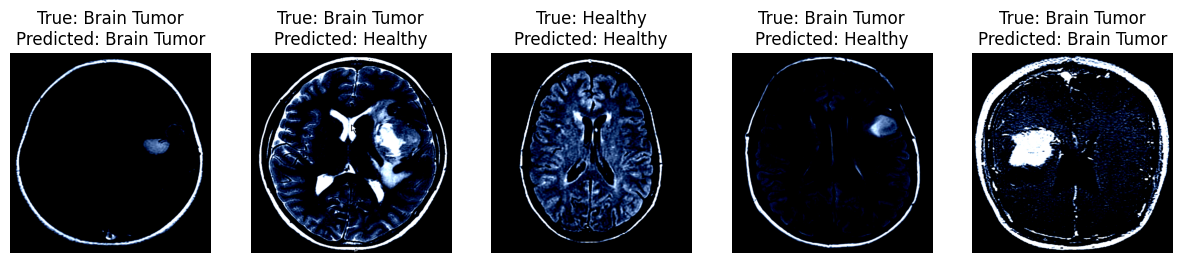

In [42]:
# Display some images and their predictions
num_images_to_display = 5
indices = torch.randint(len(y_pred), (num_images_to_display,))
indices = indices.tolist()  # Convert indices to a list

# Display some images and their predictions
display_images([test_dataset[i][0] for i in indices], y_true[indices], y_pred[indices])